# Body pose estimator

In [1]:
# Imports
import cv2
import numpy as np
import torchvision
from torchvision import transforms as T
import matplotlib.pyplot as plt

c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a model object from the keypointrcnn_resnet50_fpn class
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

# Call the eval() method to prepare the model for inference mode.
model.eval()
 
# Create the list of keypoints.
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

In [3]:
# Load image
img1 = cv2.imread("../../data/running_person.jpg")
img2 = cv2.imread("../../data/standing_person.jpg")
img = img2

In [4]:
# Preprocess the input image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
 
# Forward-pass the model, the input is a list, hence the output will also be a list
output = model([img_tensor])[0]

In [5]:
def draw_keypoints_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # pick a set of N color-ids from the spectrum
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    # iterate for every person detected
    for person_id in range(len(all_keypoints)):
      # check the confidence score of the detected person
      if confs[person_id]>conf_threshold:
        # grab the keypoint-locations for the detected person
        keypoints = all_keypoints[person_id, ...]
        # grab the keypoint-scores for the keypoints
        scores = all_scores[person_id, ...]
        # iterate for every keypoint-score
        for kp in range(len(scores)):
            # check the confidence score of detected keypoint
            if scores[kp]>keypoint_threshold:
                # convert the keypoint float-array to a python-list of integers
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                # pick the color at the specific color-id
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                # draw a circle over the keypoint location
                cv2.circle(img_copy, keypoint, 5, color, -1)
 
    return img_copy

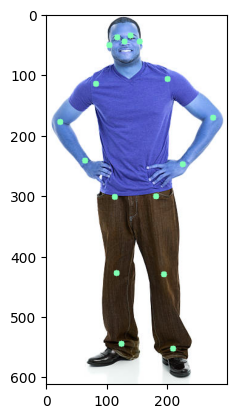

In [6]:
keypoints_img = draw_keypoints_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"], keypoint_threshold=2)

# Show
plt.imshow(keypoints_img)
plt.show()


In [7]:
def get_limbs_from_keypoints(keypoints):
  limbs = [       
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
        ]
  return limbs
 
limbs = get_limbs_from_keypoints(keypoints)

In [8]:
def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
     
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # check if the keypoints are detected
    if len(output["keypoints"])>0:
      # pick a set of N color-ids from the spectrum
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      # iterate for every person detected
      for person_id in range(len(all_keypoints)):
          # check the confidence score of the detected person
          if confs[person_id]>conf_threshold:
            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]
 
            # iterate for every limb 
            for limb_id in range(len(limbs)):
              # pick the start-point of the limb
              limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
              # pick the start-point of the limb
              limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
              # consider limb-confidence score as the minimum keypoint score among the two keypoint scores
              limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
              # check if limb-score is greater than threshold
              if limb_score> keypoint_threshold:
                # pick the color at a specific color-id
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                # draw the line for the limb
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 3)
 
    return img_copy

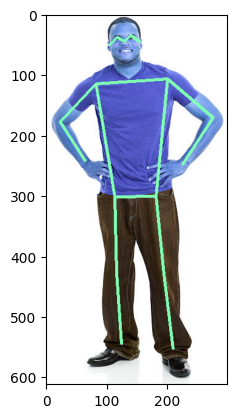

In [9]:
# overlay the skeleton in the detected person
skeletal_img = draw_skeleton_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)

# Show
plt.imshow(skeletal_img)
plt.show()
